In [143]:
library(ggplot2)
library(data.table)
library(repr)
library(ggpubr)
setwd('/data6/Angelo/alexcc/AngeloStrainsPaper/manuscript_materials/soil_popgen/notebooks')

In [144]:
high_fst = read.csv('../data_tables/high_fst.data', sep="\t")
high_fst$locus_block = paste(high_fst$genome, high_fst$locus, sep="_")

In [146]:
length(unique(high_fst$locus_block))

[1] 48

In [169]:
### Compare N:S ratios of high FST genes
files = Sys.glob('../data/all/snps/*.tsv')
ratios = c()
for (f in files){
    d = fread(f)
    d2 = d[which(d$gene %in% high_fst$gene),]
    if (nrow(d2) > 0) {
        n_mut = nrow(d2[which(d2$mutation_type == 'N'),])
        s_mut = nrow(d2[which(d2$mutation_type == 'S'),])

        n_mut_all = nrow(d[which(d$mutation_type == 'N'),])
        s_mut_all = nrow(d[which(d$mutation_type == 'S'),])
        ratios = c(ratios, ((n_mut / s_mut) / (n_mut_all / s_mut_all) ))
    }
}
print(ratios)
print(mean(ratios, na.rm=TRUE))

 [1] 1.0850034 1.3483194 1.0129852 1.4452854 1.0610543 1.0378679 1.0206531
 [8] 1.4516159 0.8734368 0.7094214 1.2801167 2.1495109 0.8236176
[1] 1.176838


In [170]:
## Find high Fst loci with significant linkage
significant_linkage <- data.frame('genome' = character(), 'locus_num' = numeric(), 
                     'genomic_mean_linkage' = numeric(),'high_fst_mean_linkage' = numeric(),'pvalue' = numeric(),
                      stringsAsFactors = FALSE)
i = 0
files = Sys.glob("../data/all/linkage/*.tsv")

for (f in files){
    genome = strsplit(strsplit(f, split = '/')[[1]][5], split='\\.')[[1]][1]
    d = fread(f)
    ## Linkage
    d = d[which(d$gene_A == d$gene_B),]
    
    for (lb in unique(high_fst$locus_block[which(high_fst$genome == genome)])){
        i = i + 1
        genes = high_fst[which(high_fst$locus_block == lb),]$gene
            
        ## Get linkage data
        linkage_genome = d
        high_fst_linkage = d[which(d$gene_A %in% genes),]
        if (nrow(high_fst_linkage) > 4){
            w2 =wilcox.test(high_fst_linkage$r2, linkage_genome$r2, alternative = 'greater')
            significant_linkage[nrow(significant_linkage) + 1,] = list(genome, lb,  
                      mean(high_fst_linkage$r2, na.rm=TRUE),mean(linkage_genome$r2, na.rm=TRUE),
                      w2$p.value)
        }
        
    }

}


In [171]:
significant_linkage = significant_linkage[which(p.adjust(significant_linkage$pvalue, method='BH') < 0.05),]

In [172]:
## Find high Fst loci with significant nucleotide diversity
files = Sys.glob('../data/fst/*.tsv')

significant_pi <- data.frame('genome' = character(), 'locus_num' = character(), 'block1' = character(),
                      'block2' = character(), 'block' = numeric(), 'pi' = numeric(),
                      'type' = numeric(), 'pvalue' = numeric(),
                      stringsAsFactors = FALSE)

i = 0
for (locus_block in unique(high_fst$locus_block)){
    genome = high_fst[which(high_fst$locus_block == locus_block),]$genome[1]
    block1 = as.character(high_fst[which(high_fst$locus_block == locus_block),]$block1[1])
    block2 = as.character(high_fst[which(high_fst$locus_block == locus_block),]$block2[1])
    genes = high_fst[which(high_fst$locus_block == locus_block),]$gene
    file = paste(genome, block1, block2, sep=":")
    d = fread(paste0('../data/fst/',file,'.Fst.tsv'))
    
    high_fst_data = d[which(d$gene %in% genes),]
    if (nrow(high_fst_data) > 4){
        w1 = t.test(high_fst_data$pi_1, d$pi_1)
        
        significant_pi[nrow(significant_pi) + 1,] = list(genome, locus_block, block1, block2, 
            block1, mean(high_fst_data$pi_1, na.rm=TRUE), 'high_fst', w1$p.value)
        significant_pi[nrow(significant_pi) + 1,] = list(genome, locus_block, block1, block2, 
            block1, mean(d$pi_1, na.rm=TRUE), 'all', w1$p.value)
        
        w2 = t.test(high_fst_data$pi_2, d$pi_2)        
        significant_pi[nrow(significant_pi) + 1,] = list(genome, locus_block, block1, block2, 
            block2, mean(high_fst_data$pi_2, na.rm=TRUE), 'high_fst', w2$p.value)
        significant_pi[nrow(significant_pi) + 1,] = list(genome, locus_block, block1, block2, 
            block2, mean(d$pi_2, na.rm=TRUE), 'all', w2$p.value)
        
    }
}
significant_pi = significant_pi[which(p.adjust(significant_pi$pvalue, method='BH') < 0.05),]

In [188]:
nrow(significant_pi) / 2

[1] 23

In [179]:
significant_pi$locus_block = paste(significant_pi$locus_num, significant_pi$block, sep="_")

In [180]:
nrow(significant_pi_final) / 2
nrow(significant_linkage)

[1] 12

[1] 30

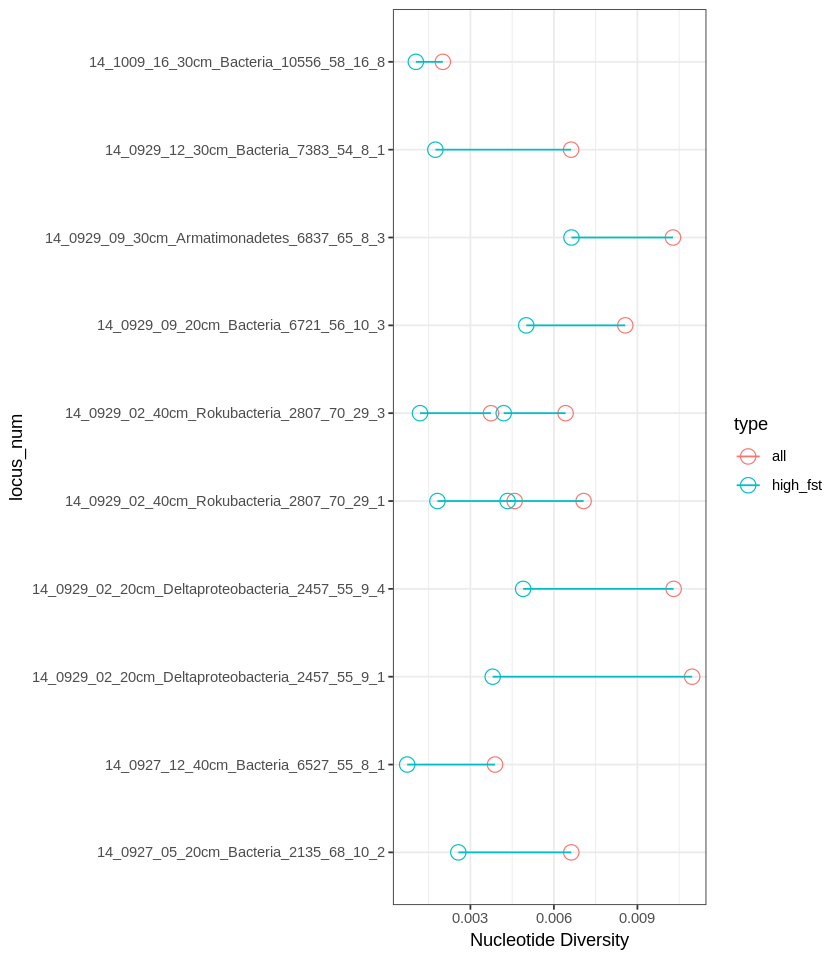

In [183]:
## Make nucleotide diversity fig
significant_pi_final = significant_pi[which(significant_pi$locus_num %in% significant_linkage$locus_num),]

options(repr.plot.width=7, repr.plot.height=8)
# pdf(file='sweeps.pdf', width=7,height=8)
ggplot(data=significant_pi_final, aes(x=pi, group=type,colour=type, y=locus_num)) + geom_point(shape=1,size=4) + theme_bw() + 
xlab("Nucleotide Diversity") + geom_line(aes(group=locus_block))
# dev.off()

In [189]:
## Make linkage boxplots
significant_linkage_final = significant_linkage[which(significant_linkage$locus_num %in% significant_pi$locus_num),]

options(repr.plot.width=5, repr.plot.height=1.7)

for (g_l in unique(high_fst$locus_block)){
    g = high_fst[which(high_fst$locus_block == g_l),]$genome[1]
    g_data = linkage_data[which(linkage_data$genome == g),]
    
    g_data$type = 'All'
    if (length(which(high_fst$locus_block == g_l)) > 1) {
        if (length(which(g_data$gene %in% high_fst[which(high_fst$locus_block == g_l),]$gene)) > 1){
            g_data[which(g_data$gene %in% high_fst[which(high_fst$locus_block == g_l),]$gene),]$type='High_FST'
        }
    }

    if (g_l %in% significant_linkage_final$locus_num){
              
        g <- ggboxplot(g_data, y = "r2",
                    color = "type", 
                    shape=NA) + coord_flip() + scale_color_manual(values = c("#25376a", "#ff0000")) + 
             ggtitle(g_l) + theme(plot.title = element_text(size=8)) + ylim(0,1)
#         pdf(file = paste0(g_l, "_LINKED.pdf"), width = 5, height=1.7)
        print(g)
#         dev.off()
    }
}

In [192]:
significant_pi_final

,genome,locus_num,block1,block2,block,pi,type,pvalue,locus_block
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
11,3,14_0927_05_20cm_Bacteria_2135_68_10_2,5_2,16_13,16_13,0.0025660896,high_fst,6.630756e-04,14_0927_05_20cm_Bacteria_2135_68_10_2_16_13
12,3,14_0927_05_20cm_Bacteria_2135_68_10_2,5_2,16_13,16_13,0.0066234450,all,6.630756e-04,14_0927_05_20cm_Bacteria_2135_68_10_2_16_13
51,5,14_0927_12_40cm_Bacteria_6527_55_8_1,5_2,12_9,12_9,0.0007281445,high_fst,4.401810e-07,14_0927_12_40cm_Bacteria_6527_55_8_1_12_9
52,5,14_0927_12_40cm_Bacteria_6527_55_8_1,5_2,12_9,12_9,0.0038845371,all,4.401810e-07,14_0927_12_40cm_Bacteria_6527_55_8_1_12_9
59,6,14_0929_02_20cm_Deltaproteobacteria_2457_55_9_1,16_13,12_9,12_9,0.0038011312,high_fst,1.542547e-03,14_0929_02_20cm_Deltaproteobacteria_2457_55_9_1_12_9
60,6,14_0929_02_20cm_Deltaproteobacteria_2457_55_9_1,16_13,12_9,12_9,0.0109668418,all,1.542547e-03,14_0929_02_20cm_Deltaproteobacteria_2457_55_9_1_12_9
71,6,14_0929_02_20cm_Deltaproteobacteria_2457_55_9_4,5_2,12_9,12_9,0.0048938769,high_fst,7.399224e-03,14_0929_02_20cm_Deltaproteobacteria_2457_55_9_4_12_9
72,6,14_0929_02_20cm_Deltaproteobacteria_2457_55_9_4,5_2,12_9,12_9,0.0103018745,all,7.399224e-03,14_0929_02_20cm_Deltaproteobacteria_2457_55_9_4_12_9
97,7,14_0929_02_40cm_Rokubacteria_2807_70_29_1,16_13,12_9,16_13,0.0018157504,high_fst,1.007312e-06,14_0929_02_40cm_Rokubacteria_2807_70_29_1_16_13


In [198]:
write.table(high_fst[which(high_fst$locus_block %in% significant_pi_final$locus_num),])

"gene" "locus_num" "genome" "block1" "block2" "locus_block"
"13" "14_0927_05_20cm_scaffold_503_17" 2 "14_0927_05_20cm_Bacteria_2135_68_10" "5_2" "16_13" "14_0927_05_20cm_Bacteria_2135_68_10_2"
"14" "14_0927_05_20cm_scaffold_503_18" 2 "14_0927_05_20cm_Bacteria_2135_68_10" "5_2" "16_13" "14_0927_05_20cm_Bacteria_2135_68_10_2"
"15" "14_0927_05_20cm_scaffold_503_19" 2 "14_0927_05_20cm_Bacteria_2135_68_10" "5_2" "16_13" "14_0927_05_20cm_Bacteria_2135_68_10_2"
"16" "14_0927_05_20cm_scaffold_503_20" 2 "14_0927_05_20cm_Bacteria_2135_68_10" "5_2" "16_13" "14_0927_05_20cm_Bacteria_2135_68_10_2"
"17" "14_0927_05_20cm_scaffold_503_21" 2 "14_0927_05_20cm_Bacteria_2135_68_10" "5_2" "16_13" "14_0927_05_20cm_Bacteria_2135_68_10_2"
"79" "14_0927_12_40cm_scaffold_4891_20" 1 "14_0927_12_40cm_Bacteria_6527_55_8" "5_2" "12_9" "14_0927_12_40cm_Bacteria_6527_55_8_1"
"80" "14_0927_12_40cm_scaffold_4891_22" 1 "14_0927_12_40cm_Bacteria_6527_55_8" "5_2" "12_9" "14_0927_12_40cm_Bacteria_6527_55_8_1"
"81" "14_0927